In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from typing import Dict
from sklearn.cluster import DBSCAN
from collections import Counter
from wishart import Wishart
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier,  DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, accuracy_score, classification_report
from scipy.stats import kurtosis
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.utils import resample
from joblib import dump, load
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score

In [190]:
def get_lorenz():
    def runge_kutta(time_steps, y0, system, params):
        ys = [y0]
        for t in range(len(time_steps)-1):
            dt = time_steps[t+1]-time_steps[t]
            t0 = time_steps[t]
            t1 = time_steps[t+1]
            k1 = system(t0, y0, params)
            k2 = system(t0 + dt/2, y0 + dt / 2 * k1, params)
            k3 = system(t0 + dt/2, y0 + dt / 2 * k2, params)
            k4 = system(t1, y0 + dt * k3, params)
            y0  = y0 + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
            ys.append(y0)
        return np.array(ys)

    def lorentz_ode(t, xyz, params):
        x, y, z = xyz
        σ = params['σ']
        ρ = params['ρ']
        β = params['β']

        dx = σ * (y - x)
        dy = x * (ρ - z) - y
        dz = x * y - β * z

        return np.array([dx, dy, dz])

    time_steps = np.arange(0, 1500, 0.1)
    params = {'σ' : 10., 'ρ' : 28., 'β' : 8/3}
    xyz0 = np.array([1., 1., 1.])
    lorenz_solution = runge_kutta(time_steps, xyz0, lorentz_ode, params)
    x, y, z = lorenz_solution[2000:].T
    x = (x - min(x)) / (max(x) - min(x))
    return x

In [191]:
X = get_lorenz()

In [192]:
pred_values = np.load("arrays.npz")
values = [pred_values[key] for key in pred_values]

pred_means = np.load('dbscan_predictions.npz')
means = [pred_means[key] for key in pred_means]
means = list(means[0])

In [193]:
means = [np.mean(value) for value in values]

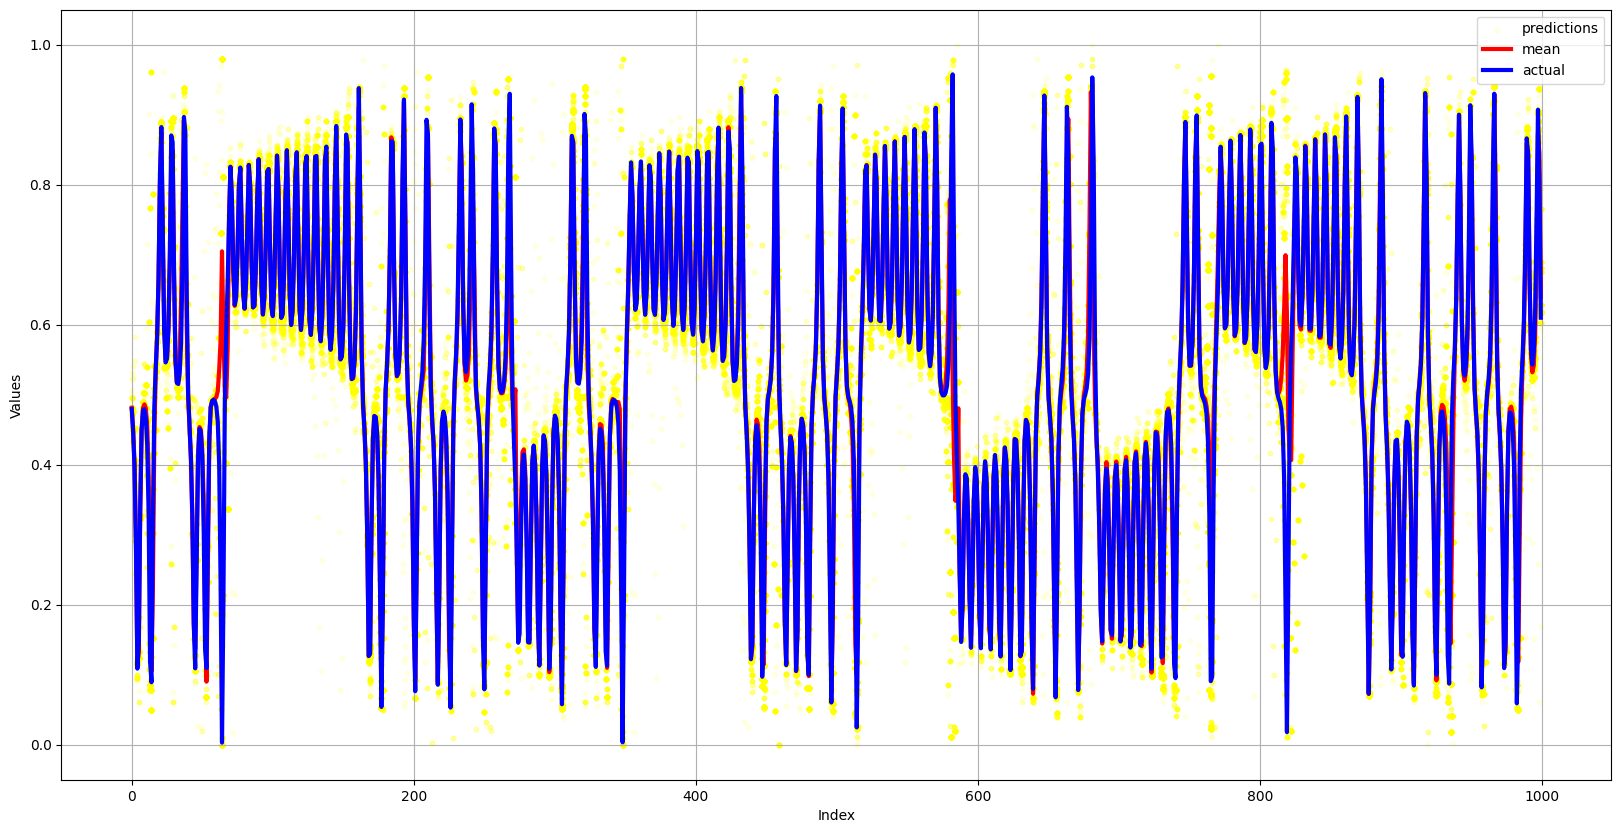

In [194]:
concatenated = np.concatenate(values)

x = np.repeat(np.arange(len(values)), [len(arr) for arr in values])

y = concatenated

plt.figure(figsize=(20, 10))

plt.scatter(x, y, color='yellow', alpha=0.1, s=10, label='predictions')

plt.plot(means, color='red', label='mean', linewidth=3)

plt.plot(X[5000: 6000], color='blue', label='actual', linewidth=3)

plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid()

plt.show()

In [195]:
error = list(abs(means - X[5000:6000]))

In [196]:
def get_counts(values, N = 20):
    intervals = np.linspace(0, 1, N + 1)
    result = np.zeros(N)
    
    for i in range (N):
        result[i] = np.sum((values >= intervals[i]) & (values < intervals[i + 1])) / len(values)
        
    return result

In [197]:
error = np.array(error)
error = error > 0.025

In [198]:
values = [get_counts(values[i]) for i in range (len(values))]

In [199]:
X_train, X_test, y_train, y_test = train_test_split(values, error, test_size=0.1, random_state=42)

In [200]:
%%time

model = GradientBoostingClassifier(random_state=42)

param_grid = {
    'learning_rate': [0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5],
    'n_estimators': [400, 450, 500, 550, 600, 700],
    'max_depth': [7, 10, 12, 14]
}

recall_scorer = make_scorer(recall_score)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=recall_scorer,
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший recall на кросс-валидации:", grid_search.best_score_)

best_model = grid_search.best_estimator_
preds = best_model.predict(X_test)

TP = np.sum(np.logical_and(y_test, preds))
FN = np.sum(np.logical_and(y_test, ~preds))
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
print("Recall на тестовой выборке:", recall)

Fitting 5 folds for each of 168 candidates, totalling 840 fits
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 400}
Лучший recall на кросс-валидации: 0.3910256410256411
Recall на тестовой выборке: 0.23076923076923078
CPU times: user 9.96 s, sys: 337 ms, total: 10.3 s
Wall time: 57.3 s


N = 10 - 

N = 20 - 0.625

N = 30 - 0.263

N = 40 - 

N = 50 - 

N = 60 - 

N = 70 - 

N = 80 - 

N = 90 - 

N = 100 - 


In [201]:
dump(best_model, 'classifier_model.joblib')

['classifier_model.joblib']

[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=400; total time=   1.2s
[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=450; total time=   1.4s
[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=550; total time=   1.1s
[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=600; total time=   1.6s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=400; total time=   1.3s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=500; total time=   1.2s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=600; total time=   1.3s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=700; total time=   1.3s
[CV] END .learning_rate=0.05, max_depth=12, n_estimators=450; total time=   1.2s
[CV] END .learning_rate=0.05, max_depth=12, n_estimators=550; total time=   1.2s
[CV] END .learning_rate=0.05, max_depth=12, n_estimators=700; total time=   1.2s
[CV] END .learning_rate=0.05, max_depth=14, n_estimators=400; total time=   1.1s
[CV] END .learning_rate=0.05